In [1]:
from google.colab import files
uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset (1).csv


<ipython-input-25-dd7d9f0c761b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette="coolwarm")


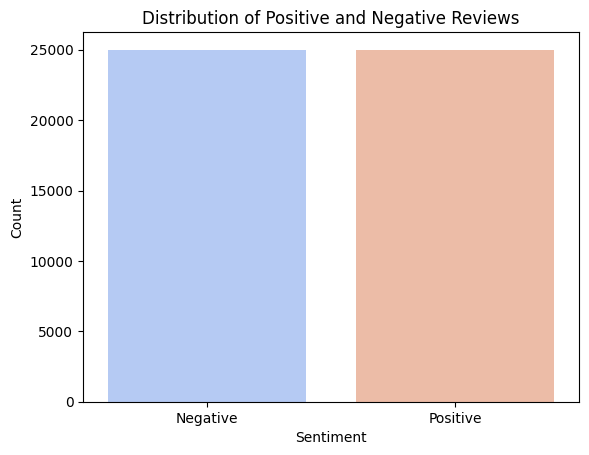

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

df = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset (1).csv']))
df.head()
# Ensure dataset has 'review' (text) and 'sentiment' (labels)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert labels to binary (1=positive, 0=negative)
# Visualize class distribution
sns.countplot(x=df['sentiment'], palette="coolwarm")
plt.title("Distribution of Positive and Negative Reviews")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


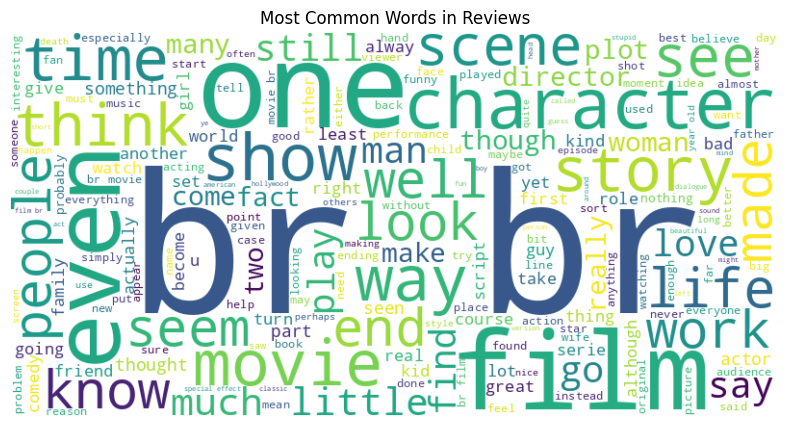

In [30]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Generate Word Cloud
text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")


Training Samples: 40000, Testing Samples: 10000


Accuracy: 0.8882
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



<Figure size 600x400 with 0 Axes>

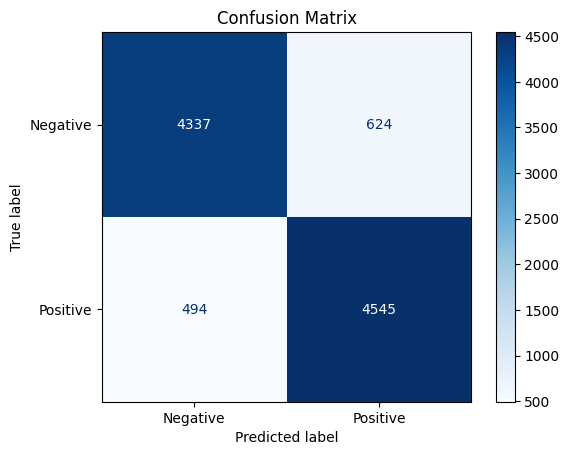

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.7915 - loss: 0.4369 - val_accuracy: 0.8756 - val_loss: 0.2966
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.9073 - loss: 0.2425 - val_accuracy: 0.8864 - val_loss: 0.2694
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.9293 - loss: 0.1927 - val_accuracy: 0.8784 - val_loss: 0.2914
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.9481 - loss: 0.1448 - val_accuracy: 0.8817 - val_loss: 0.3153
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - accuracy: 0.9626 - loss: 0.1095 - val_accuracy: 0.8744 - val_loss: 0.3373


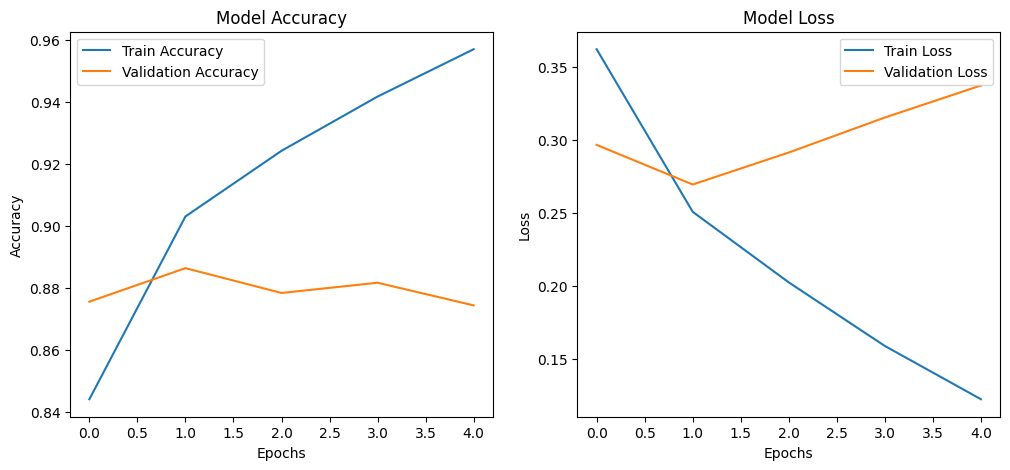

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenization for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_padded = pad_sequences(X_seq, maxlen=100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Plot training accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [12]:
import pickle

# Save ML Model
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save Vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Load Model
with open("sentiment_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
